In [1]:
import argparse, os, time
import pandas as pd
import geopandas as gpd
import polars as pl
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import matplotlib.patheffects as path_effects
from matplotlib.cm import get_cmap
from matplotlib.patches import Patch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from collections import defaultdict
import warnings
from tqdm import tqdm
import pickle
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd


tqdm.pandas()
warnings.filterwarnings("ignore")

In [2]:
year = 20
pred_csv = f"./output/donors_state{year}_pred_lastname.csv"
donors_csv = f"./data/CampaignFin{year}/donors_recip{year}.csv"
cands_csv = f"./data/CampaignFin{year}/cands{year}.txt"

In [3]:
donors = pd.read_csv(donors_csv)
donors.head(10)

,contrib_id,recip_id,name,name_new,realcode,gender,occupation,employer,city,state,total_donated,donation_count,avg_donation,med_donation
0,U00000037041,N00029349,"BLOOMBERG, MICHAEL R",michael r bloomberg,Z9000,M,FOUNDER,BLOOMBERG INC.,NEW YORK,NY,1.086565e+09,868,1.251802e+06,612.0
1,U00000036521,N00044966,"STEYER, TOM",tom steyer,Z9000,M,PRESIDENTIAL CANDIDATE,SELF-EMPLOYED,SAN FRANCISCO,CA,3.179460e+08,582,5.462989e+05,2036.5
2,,N00001669,"INFORMATION REQUESTED, INFORMATION",information information requested,Y4000,,NaN,NaN,NEW YORK,CA,9.947018e+07,589,1.688798e+05,250.0
3,,C00484642,MAJORITY FORWARD,majority forward majority forward,Z9600,,NaN,NaN,WASHINGTON,DC,9.866908e+07,122,8.087629e+05,117035.5
4,,C00618371,WINRED,winred winred,Z9600,,NaN,NaN,ARLINGTON,VA,9.195982e+07,197,4.668011e+05,500.0
5,,C00571703,CHEVRON CORPORATION,koch industries inc koch industries inc,Y4000,,NaN,NaN,WASHINGTON,TX,6.460129e+07,212,3.047231e+05,50000.0
6,,C00495028,CHC BOLD PAC,chc bold pac chc bold pac,Z9600,,NaN,NaN,WASHINGTON,DC,5.408387e+07,207,2.612747e+05,70000.0
7,,C00693382,FUND FOR POLICY REFORM,fund for policy reform fund for policy reform,J1200,,NaN,NaN,WILMINGTON,DE,4.950000e+07,7,7.071429e+06,6000000.0
8,,C00669259,FUTURE FORWARD USA ACTION,future forward usa action future forward usa a...,J1200,,NaN,NaN,WASHINGTON,DC,4.526326e+07,27,1.676417e+06,100000.0
9,,C00504530,AMERICAN ACTION NETWORK,american action network american action network,Z9600,,NaN,NaN,WASHINGTON,DC,4.465169e+07,138,3.235630e+05,100000.0


In [4]:
cands_lf = (
        pl.scan_csv(
            cands_csv,
            separator=',', 
            quote_char='|', 
            encoding='utf8-lossy', 
            has_header=False,
            new_columns=['dummy1', 'id', 'recip_id', 'name', 'party', 
                        'seat', 'seat_current', 'ran_general', 'ran_ever', 'type', 
                        'recipcode', 'nopacs'],
            ignore_errors=True
        )
        .select(['id', 'recip_id', 'name', 'party', 'seat', 'seat_current', 
                 'ran_general', 'ran_ever', 'type', 'recipcode'])
    )

cands = cands_lf.collect()
cands = cands.to_pandas()
cands = cands.drop_duplicates(subset=['recip_id', 'name', 'party', 'seat'], keep='last')
cands[(cands["seat"] == "PRES") & (cands["ran_general"] == "Y")]

,id,recip_id,name,party,seat,seat_current,ran_general,ran_ever,type,recipcode
6211,P00013524,N00011042,Jo Jorgensen (L),L,PRES,,Y,Y,C,3L
6278,P00014209,N00042370,Don Blankenship (3),3,PRES,,Y,Y,C,3L
6934,P80000722,N00001669,Joe Biden (D),D,PRES,,Y,Y,C,DW
6936,P80001571,N00023864,Donald Trump (R),R,PRES,PRES,Y,Y,I,RL


In [5]:
cands[cands["recip_id"].str.contains("N")]

,id,recip_id,name,party,seat,seat_current,ran_general,ran_ever,type,recipcode
0,H0AK00105,N00039029,Thomas Lamb (I),I,AK01,,,Y,C,3N
1,H0AK00113,N00047445,Ray Sean Tugatuk (D),D,AK01,,,Y,C,DL
3,H0AL01055,N00044245,Jerry Carl (R),R,AL01,,Y,Y,O,RW
4,H0AL01063,N00044288,Wes Lambert (R),R,AL01,,,Y,O,RL
5,H0AL01071,N00025369,Chris Pringle (R),R,AL01,,,Y,O,RL
...,...,...,...,...,...,...,...,...,...,...
8055,S8WV00135,N00041474,Bo Copley (R),R,WVS1,,,,,RN
8056,S8WV00143,N00012642,Patrick Morrisey (R),R,WVS1,,,,,RN
8057,S8WY00189,N00027793,Gary Trauner (D),D,WYS1,,,,,DN
8058,S8WY00197,N00042998,David Dodson (R),R,WYS1,,,,,RN


In [6]:
mapping = {
    'A': 'Agribusiness',
    'B': 'Construction',
    'C': 'Tech',
    'D': 'Defense',
    'E': 'Energy',
    'F': 'Finance',
    'M': 'Misc Business',
    'H': 'Health',
    'J': 'Ideology/Single Issue',
    'K': 'Law',
    'L': 'Labor',
    'M': 'Manufacturing',
    'T': 'Transportation',
    'W': 'Other',
    'Y': 'Unknown',
    'Z': 'Party'
}

donors["sector"] = donors["realcode"].apply(lambda x: str(x).upper()[0]).map(mapping)
donors["sector"].value_counts()

sector
Party                    1299587
Unknown                  1036328
Ideology/Single Issue     861610
Health                    541522
Finance                   443132
Tech                      224719
Law                       199207
Construction              122016
Transportation            118605
Labor                     112626
Energy                     89268
Agribusiness               73594
Manufacturing              55259
Defense                    37952
Name: count, dtype: int64

In [7]:
preds = pd.read_csv(pred_csv)
donors = donors.merge(preds[['contrib_id', 'ethnic']], on='contrib_id', how='left')
donors = donors.merge(cands, on='recip_id', how='left')

In [8]:
contrib_party_totals = (
    donors.groupby(['contrib_id', 'name_new', 'party'])['total_donated']
    .sum()
    .unstack()
    .fillna(0)
)

contrib_party_totals['dem_ratio'] = (
    contrib_party_totals.get('D', 0) / 
    (contrib_party_totals.get('D', 0) + contrib_party_totals.get('R', 0))
)

donors = donors.merge(
    contrib_party_totals['dem_ratio'].reset_index(),
    on=['contrib_id', 'name_new'],
    how='left'
)

donors

,contrib_id,recip_id,name_x,name_new,realcode,gender,occupation,employer,city,state,...,id,name_y,party,seat,seat_current,ran_general,ran_ever,type,recipcode,dem_ratio
0,U00000037041,N00029349,"BLOOMBERG, MICHAEL R",michael r bloomberg,Z9000,M,FOUNDER,BLOOMBERG INC.,NEW YORK,NY,...,P00014530,Michael Bloomberg (D),D,PRES,,,Y,C,DL,1.0
1,U00000036521,N00044966,"STEYER, TOM",tom steyer,Z9000,M,PRESIDENTIAL CANDIDATE,SELF-EMPLOYED,SAN FRANCISCO,CA,...,P00012716,Tom Steyer (D),D,PRES,,,Y,C,DL,1.0
2,,N00001669,"INFORMATION REQUESTED, INFORMATION",information information requested,Y4000,,NaN,NaN,NEW YORK,CA,...,P80000722,Joe Biden (D),D,PRES,,Y,Y,C,DW,1.0
3,,C00484642,MAJORITY FORWARD,majority forward majority forward,Z9600,,NaN,NaN,WASHINGTON,DC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,,C00618371,WINRED,winred winred,Z9600,,NaN,NaN,ARLINGTON,VA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7136705,h3001209792,N00040675,"GOULD, COLIN",colin gould,C5120,M,SOFTWARE INFRASTRUCTURE ARCHITECT,ORACLE,FOSTER CITY,CA,...,S8GA00180,Jon Ossoff (D),D,GAS1,,Y,Y,C,DW,1.0
7136706,p0001372401,C00003418,"BLEDSOE, PEARLIOUS MS",pearlious ms bledsoe,X1200,F,RETIRED,RETIRED,GRANITEVILLE,SC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7136707,r0006423692,C00003418,"CARMICHAEL, RUTH",ruth carmichael,X1200,F,RETIRED,RETIRED,KANSAS CITY,KS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
7136708,r0015995400,C00003418,"BOOKATZ, DEBRA MRS",debra mrs bookatz,Y4000,F,RETIRED,MARINE CORP. COMMUNITY SERVICES,KANEOHE,HI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
donors["level"] = donors["seat"].apply(lambda x: "Senate" if "S1" in str(x) or "S2" in str(x) else "President" if str(x) == "PRES" else "House" if type(x) == str and len(str(x)) == 4 else "Unknown")
donors["level"].value_counts()

level
Unknown      3447415
Senate       1462833
President    1380460
House         846002
Name: count, dtype: int64

In [10]:
def read_and_process_donors_csv(year):
    
    # define files
    pred_csv = f"./output/donors_state{year}_pred_lastname.csv"
    donors_csv = f"./data/CampaignFin{year}/donors_recip{year}.csv"
    cands_csv = f"./data/CampaignFin{year}/cands{year}.txt"
    
    # read donors csv
    donors = pd.read_csv(donors_csv)
    
    # read cands csv
    cands_lf = (
        pl.scan_csv(
            cands_csv,
            separator=',', 
            quote_char='|', 
            encoding='utf8-lossy', 
            has_header=False,
            new_columns=['dummy1', 'id', 'recip_id', 'name', 'party', 
                        'seat', 'seat_current', 'ran_general', 'ran_ever', 'type', 
                        'recipcode', 'nopacs'],
            ignore_errors=True
        )
        .select(['id', 'recip_id', 'name', 'party', 'seat', 'seat_current', 
                 'ran_general', 'ran_ever', 'type', 'recipcode'])
    )

    cands = cands_lf.collect()
    cands = cands.to_pandas()
    cands = cands.drop_duplicates(subset=['recip_id', 'name', 'party', 'seat'], keep='last')
    
    # map sectors
    donors["sector"] = donors["realcode"].apply(lambda x: str(x).upper()[0]).map(mapping)
    
    # merge the three csvs
    preds = pd.read_csv(pred_csv)
    donors = donors.merge(preds[['contrib_id', 'ethnic']], on='contrib_id', how='left')
    donors = donors.merge(cands, on='recip_id', how='left')
    
    # calculate dem ratio
    contrib_party_totals = (
        donors.groupby(['contrib_id', 'name_new', 'party'])['total_donated']
        .sum()
        .unstack()
        .fillna(0)
    )

    contrib_party_totals['dem_ratio'] = (
        contrib_party_totals.get('D', 0) / 
        (contrib_party_totals.get('D', 0) + contrib_party_totals.get('R', 0))
    )

    donors = donors.merge(
        contrib_party_totals['dem_ratio'].reset_index(),
        on=['contrib_id', 'name_new'],
        how='left'
    )
    
    # map levels
    donors["level"] = donors["seat"].apply(lambda x: "Senate" if "S1" in str(x) or "S2" in str(x) else 
                                           "President" if str(x) == "PRES" else 
                                           "House" if type(x) == str and len(str(x)) == 4 else 
                                           "Unknown")
    
    # add electoral cycle    
    donors["cycle"] = f"20{year}"

    return donors

In [11]:
all_donors = donors
all_donors["cycle"] = f"20{year}"

for year in tqdm(list(filter(lambda x: x != year, [16, 18, 20, 22]))):
    
    donors = read_and_process_donors_csv(year)
    all_donors = pd.concat([all_donors, donors], ignore_index=True)
    
all_donors["cycle"].value_counts()

100%|██████████| 3/3 [02:35<00:00, 51.77s/it]


cycle
2020    7136710
2022    6014905
2016    3884782
2018    3150099
Name: count, dtype: int64

In [12]:
all_donors

,contrib_id,recip_id,name_x,name_new,realcode,gender,occupation,employer,city,state,...,party,seat,seat_current,ran_general,ran_ever,type,recipcode,dem_ratio,level,cycle
0,U00000037041,N00029349,"BLOOMBERG, MICHAEL R",michael r bloomberg,Z9000,M,FOUNDER,BLOOMBERG INC.,NEW YORK,NY,...,D,PRES,,,Y,C,DL,1.0,President,2020
1,U00000036521,N00044966,"STEYER, TOM",tom steyer,Z9000,M,PRESIDENTIAL CANDIDATE,SELF-EMPLOYED,SAN FRANCISCO,CA,...,D,PRES,,,Y,C,DL,1.0,President,2020
2,,N00001669,"INFORMATION REQUESTED, INFORMATION",information information requested,Y4000,,NaN,NaN,NEW YORK,CA,...,D,PRES,,Y,Y,C,DW,1.0,President,2020
3,,C00484642,MAJORITY FORWARD,majority forward majority forward,Z9600,,NaN,NaN,WASHINGTON,DC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,2020
4,,C00618371,WINRED,winred winred,Z9600,,NaN,NaN,ARLINGTON,VA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Unknown,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20186491,r0014337648,C00401224,"FISKE, MARGARET",margaret fiske,Z9500,F,NaN,NaN,SAN GABRIEL,CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,2022
20186492,m0001511409,C00401224,"POLLNOW, RITA",rita pollnow,Z9500,F,NaN,NaN,DAVIS,CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Unknown,2022
20186493,r0007056936,C00003418,"MILLER, GLENN MR JR",glenn mr jr miller,X1200,M,RETIRED,RETIRED,OMAHA,NE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,2022
20186494,q0001809165,C00401224,"CAMOBELL, JEANINE",jeanine camobell,Z9500,F,NaN,NaN,PLEASANT VALLEY,NY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,2022


In [34]:
sector_counts_all = (
    all_donors[~all_donors["sector"].isin(["Unknown", "Party", "Ideology/Single Issue"])]
    .groupby(['cycle', 'sector'])
    .size()
    .unstack(fill_value=0)
)

sector_counts_indian = (
    all_donors[~all_donors["sector"].isin(["Unknown", "Party", "Ideology/Single Issue"])][all_donors["ethnic"] == "ind"]
    .groupby(['cycle', 'sector'])
    .size()
    .unstack(fill_value=0)
)

sector_pct_all = sector_counts_all.div(sector_counts_all.sum(axis=1), axis=0) * 100
sector_pct_indian = sector_counts_indian.div(sector_counts_indian.sum(axis=1), axis=0) * 100

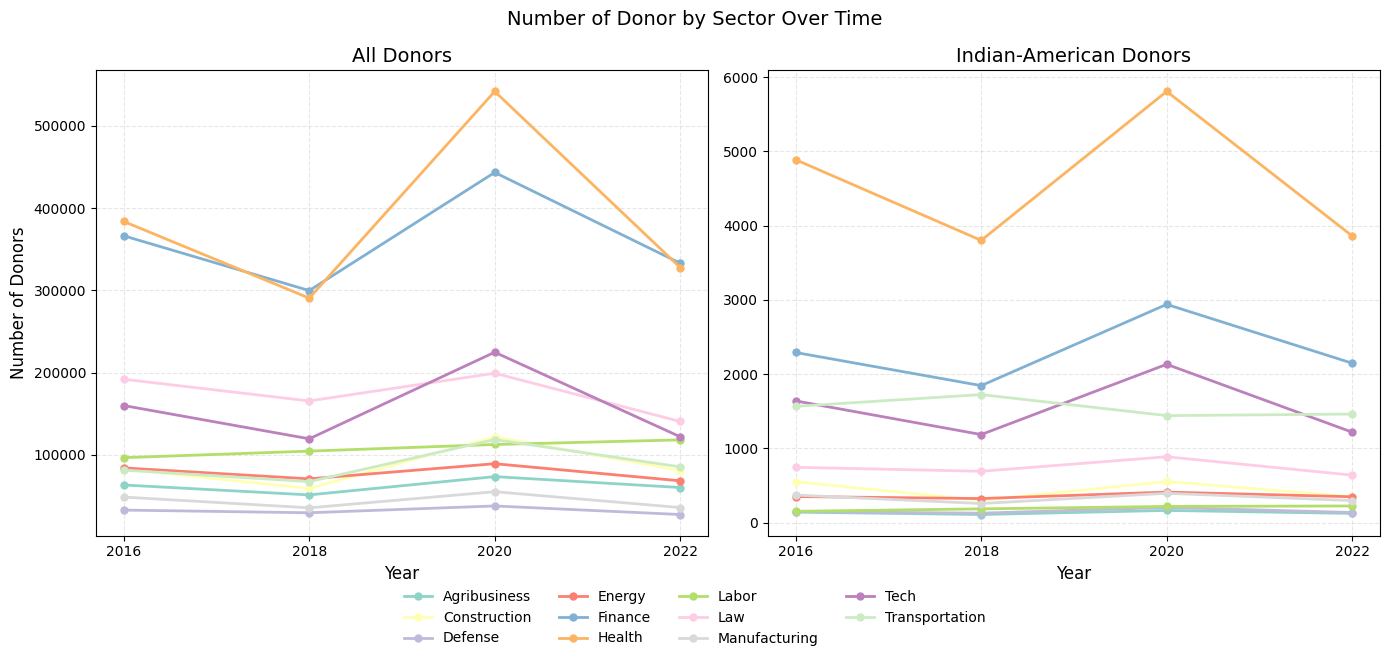

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=False)
colors = sns.color_palette("Set3", n_colors=len(sector_counts_all.columns))

for i, sector in enumerate(sector_counts_all.columns):
    ax1.plot(
        sector_counts_all.index,
        sector_counts_all[sector],
        label=sector,
        color=colors[i],
        marker='o',
        markersize=5,
        linewidth=2
    )

ax1.set_title("All Donors", fontsize=14)
ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Number of Donors", fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.3)

for i, sector in enumerate(sector_counts_indian.columns):
    ax2.plot(
        sector_counts_indian.index,
        sector_counts_indian[sector],
        label=sector,
        color=colors[i],
        marker='o',
        markersize=5,
        linewidth=2
    )

ax2.set_title("Indian-American Donors", fontsize=14)
ax2.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Number of Donors", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=10,
    frameon=False
)

plt.suptitle("Number of Donor by Sector Over Time", fontsize=14)
plt.tight_layout()
plt.show()

In [39]:
sector_counts_all

sector,Agribusiness,Construction,Defense,Energy,Finance,Health,Labor,Law,Manufacturing,Tech,Transportation
cycle,,,,,,,,,,,
2016,63413,82885,32948,84184,366169,383578,96632,191864,48753,159959,81459
2018,51386,59168,29669,70868,299623,290450,104557,165545,35686,119529,67494
2020,73598,122023,37952,89273,443146,541555,112626,199217,55266,224729,118611
2022,60358,80913,27557,68506,332856,327594,118222,140568,36013,121992,85477


In [40]:
sector_counts_indian

sector,Agribusiness,Construction,Defense,Energy,Finance,Health,Labor,Law,Manufacturing,Tech,Transportation
cycle,,,,,,,,,,,
2016,141,551,149,351,2291,4887,152,745,371,1639,1566
2018,109,299,127,324,1845,3801,185,691,257,1186,1724
2020,164,554,204,411,2939,5807,218,887,395,2132,1441
2022,124,350,136,348,2147,3861,224,639,297,1218,1462


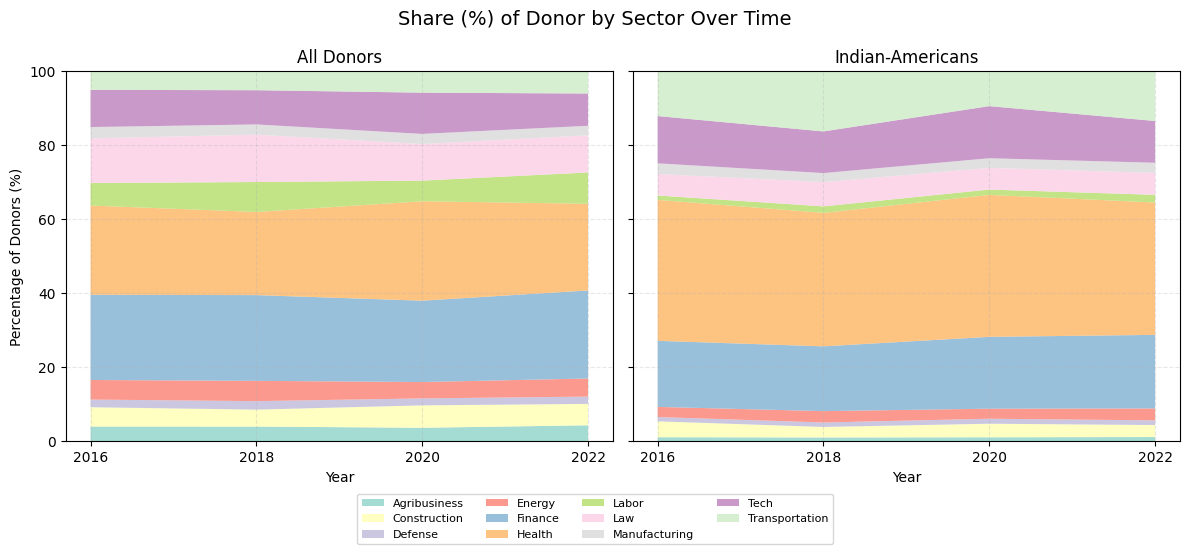

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
colors = sns.color_palette("Set3", n_colors=len(sector_pct_all.columns))

ax1.stackplot(
    sector_pct_all.index,
    sector_pct_all.T,
    labels=sector_pct_all.columns,
    colors=colors,
    alpha=0.8,
)
ax1.set_title("All Donors", fontsize=12)
ax1.set_xlabel("Year")
ax1.set_ylabel("Percentage of Donors (%)")
ax1.set_ylim(0, 100)
ax1.grid(True, linestyle='--', alpha=0.3)

ax2.stackplot(
    sector_pct_indian.index,
    sector_pct_indian.T,
    labels=sector_pct_indian.columns,
    colors=colors,
    alpha=0.8,
)
ax2.set_title("Indian-Americans", fontsize=12)
ax2.set_xlabel("Year")
ax2.grid(True, linestyle='--', alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=8
)

plt.suptitle("Share (%) of Donor by Sector Over Time", fontsize=14)
plt.tight_layout()
plt.show()

In [32]:
sector_pct_all

sector,Agribusiness,Construction,Defense,Energy,Finance,Health,Labor,Law,Manufacturing,Tech,Transportation
cycle,,,,,,,,,,,
2016,3.983619,5.206854,2.069801,5.288458,23.002819,24.096457,6.070444,12.052940,3.062674,10.048661,5.117273
2018,3.971174,4.572577,2.292857,5.476767,23.155239,22.446338,8.080295,12.793524,2.757859,9.237350,5.216020
2020,3.647084,6.046741,1.880678,4.423844,21.959707,26.836277,5.581081,9.872022,2.738658,11.136246,5.877663
2022,4.311113,5.779269,1.968278,4.893090,23.774478,23.398635,8.444091,10.040170,2.572254,8.713366,6.105256


In [36]:
sector_pct_indian

sector,Agribusiness,Construction,Defense,Energy,Finance,Health,Labor,Law,Manufacturing,Tech,Transportation
cycle,,,,,,,,,,,
2016,1.097874,4.290275,1.160165,2.733006,17.838511,38.051857,1.183524,5.800825,2.888733,12.761816,12.193413
2018,1.033371,2.834661,1.204020,3.071672,17.491468,36.035267,1.753887,6.551005,2.436481,11.243838,16.344331
2020,1.082365,3.656283,1.346357,2.712513,19.396779,38.324974,1.438754,5.854013,2.606917,14.070750,9.510296
2022,1.147511,3.238941,1.258560,3.220433,19.868592,35.730150,2.072922,5.913381,2.748473,11.271516,13.529521
